# MLP
MLP, K=5, droput, 150 epoch.

mRNA. Baseline. No exclusions. 

Like MLP_251 but use all transcripts, not just canonical.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-11 14:18:52.499905


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_263'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.pc_RCI.csv'
RCI_FILE_TEST  = None #'test.pc_RCI.csv'

SEQ_FILE_TRAIN = 'train.all_pc_transcripts.csv'
SEQ_FILE_TEST  = None #'test.all_pc_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-11 14:19:27.706111
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = 0 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = 0   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold) # lncRNA
        filename='pc.{}.{}.validation_genes.txt'.format(rep,fold) # mRNA
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            # use -2 and 0 for lncRNA, use -1 and +1 for mRNA
            in_middle = gene_to_rci[gene_id] >= -1 and gene_to_rci[gene_id] <= 1
            in_tails = gene_to_rci[gene_id] < -1 or gene_to_rci[gene_id] > 1
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-11 14:19:29.316498
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.csv
Number of RCI values loaded 13662
Num RCI: 13662
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_pc_transcripts.csv
Loaded 131211 sequences.

Training # 1 1
2023-04-11 14:24:17.899417
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.1.validation_genes.txt
2023-04-11 14:24:19.279307
Discriminator ZERO 0
Train 1:0 42680:61663 40.90%
Valid 1:0 10560:16308 39.30%
FIT
2023-04-11 14:24:20.943616


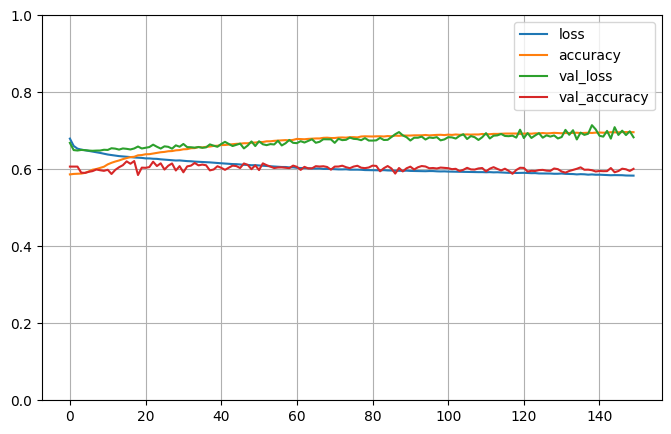


Testing # 1 1
2023-04-11 15:25:45.708778
2023-04-11 15:25:45.708963
PREDICT
2023-04-11 15:25:46.038192
Test 1:0 10560:16308 39.30%
Predict 1:0 6923:19945 25.77%
Test sizes (26868, 1025) (26868,)
Distrib of scores: 0.3923242 mean 0.17247383 std
Range of scores: 0.03127267 to 0.9624716
Score threshold 0.5
Confusion matrix
 [[12768  3540]
 [ 7177  3383]]
Normalized matrix
 [[0.47521215 0.13175525]
 [0.26712074 0.12591187]]
Extreme scores correct, pos:neg 1446 8750
Extreme scores incorrect pos:neg 1259 4444


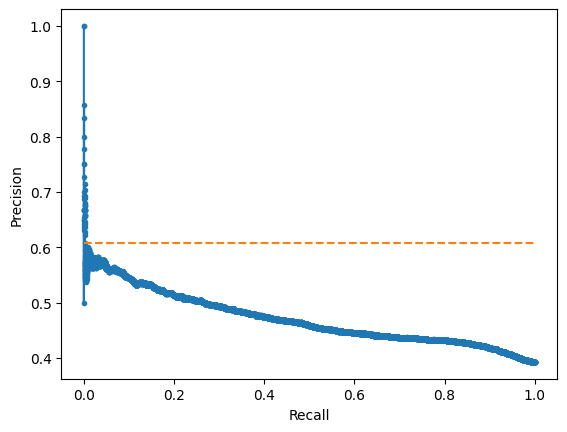

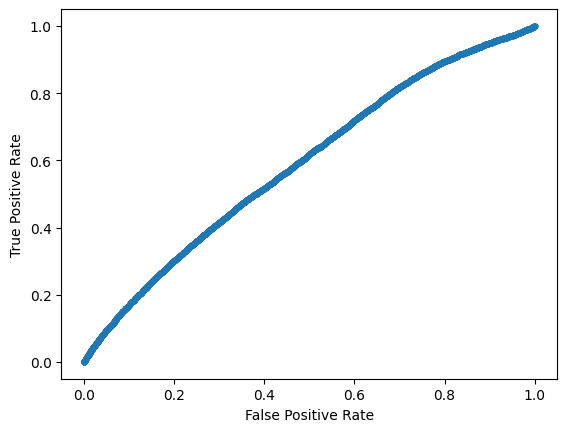

Accuracy: 60.11% Precision: 48.87% Recall: 32.04%
F1: 38.70% MCC: 0.1154
AUPRC: 47.08% AUROC: 59.07%
 accuracy [60.112401369659075]
 precision [48.86609851220569]
 recall [32.03598484848485]
 F1 [38.700451867528464]
 MCC [0.11535063219586433]
 AUPRC [47.07782350342462]
 AUROC [59.06727839933552]

Training # 1 2
2023-04-11 15:25:49.888750
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.2.validation_genes.txt
2023-04-11 15:25:51.368641
Discriminator ZERO 0
Train 1:0 42176:62771 40.19%
Valid 1:0 11064:15200 42.13%
FIT
2023-04-11 15:25:55.295753


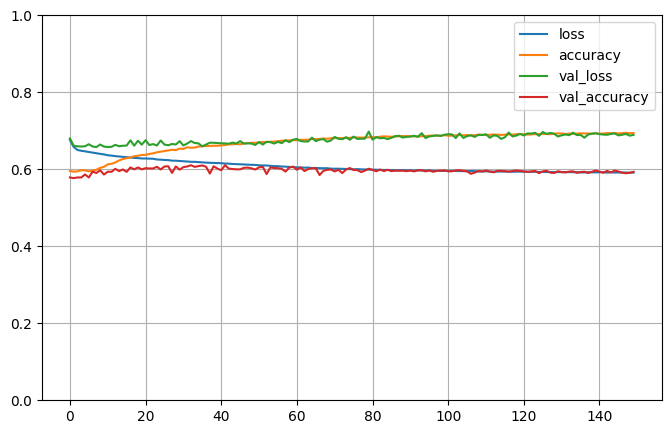


Testing # 1 2
2023-04-11 16:22:48.997965
2023-04-11 16:22:48.998117
PREDICT
2023-04-11 16:22:49.301778
Test 1:0 11064:15200 42.13%
Predict 1:0 7834:18430 29.83%
Test sizes (26264, 1025) (26264,)
Distrib of scores: 0.3995585 mean 0.18430443 std
Range of scores: 0.03626771 to 0.7051693
Score threshold 0.5
Confusion matrix
 [[11475  3725]
 [ 6955  4109]]
Normalized matrix
 [[0.43690984 0.14182912]
 [0.26481115 0.15644989]]
Extreme scores correct, pos:neg 2404 7817
Extreme scores incorrect pos:neg 1945 4199


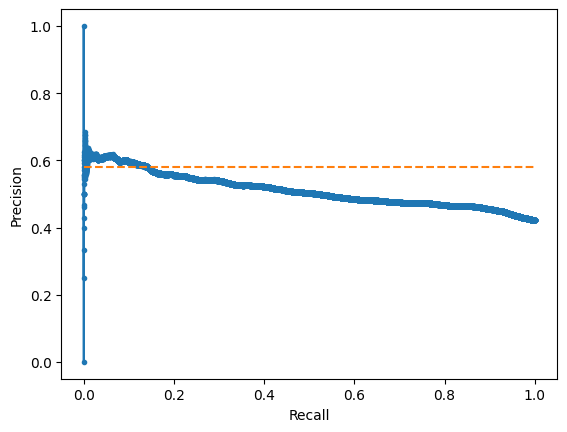

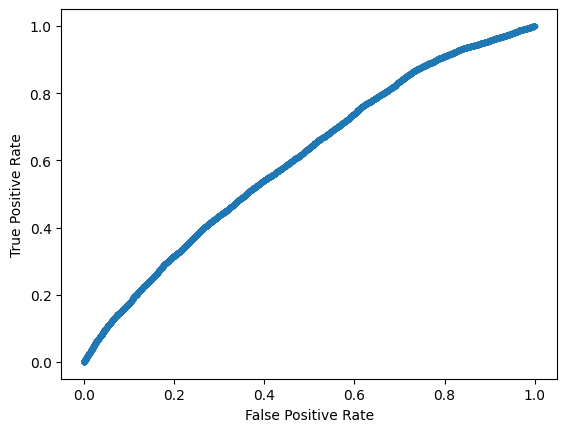

Accuracy: 59.34% Precision: 52.45% Recall: 37.14%
F1: 43.49% MCC: 0.1363
AUPRC: 51.10% AUROC: 60.57%
 accuracy [59.33597319524825]
 precision [52.45085524636202]
 recall [37.13846710050615]
 F1 [43.48608318340565]
 MCC [0.1363300826305495]
 AUPRC [51.097022750217846]
 AUROC [60.57239726043689]

Training # 1 3
2023-04-11 16:22:52.845626
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.3.validation_genes.txt
2023-04-11 16:22:54.150293
Discriminator ZERO 0
Train 1:0 42890:62917 40.54%
Valid 1:0 10350:15054 40.74%
FIT
2023-04-11 16:22:56.393692


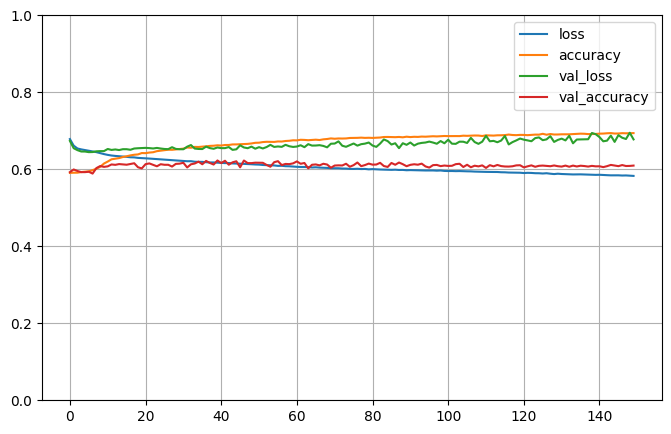


Testing # 1 3
2023-04-11 17:15:30.537038
2023-04-11 17:15:30.537279
PREDICT
2023-04-11 17:15:31.091715
Test 1:0 10350:15054 40.74%
Predict 1:0 7152:18252 28.15%
Test sizes (25404, 1025) (25404,)
Distrib of scores: 0.401297 mean 0.19111468 std
Range of scores: 0.01918287 to 0.9789693
Score threshold 0.5
Confusion matrix
 [[11694  3360]
 [ 6558  3792]]
Normalized matrix
 [[0.46032121 0.13226264]
 [0.25814832 0.14926783]]
Extreme scores correct, pos:neg 1834 8149
Extreme scores incorrect pos:neg 1368 3822


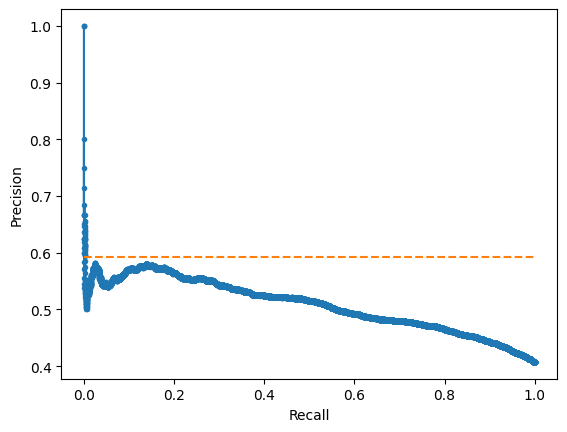

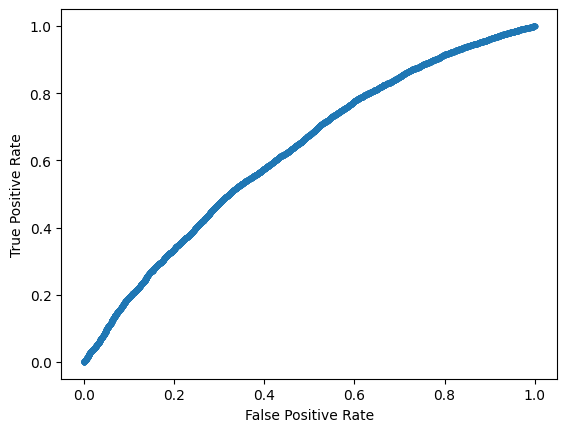

Accuracy: 60.96% Precision: 53.02% Recall: 36.64%
F1: 43.33% MCC: 0.1564
AUPRC: 50.79% AUROC: 62.54%
 accuracy [60.95890410958904]
 precision [53.02013422818792]
 recall [36.63768115942029]
 F1 [43.3321906067878]
 MCC [0.1564265522933364]
 AUPRC [50.78935563600052]
 AUROC [62.54397919502672]

Training # 1 4
2023-04-11 17:15:33.980919
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.4.validation_genes.txt
2023-04-11 17:15:35.173239
Discriminator ZERO 0
Train 1:0 42682:62515 40.57%
Valid 1:0 10558:15456 40.59%
FIT
2023-04-11 17:15:38.081418


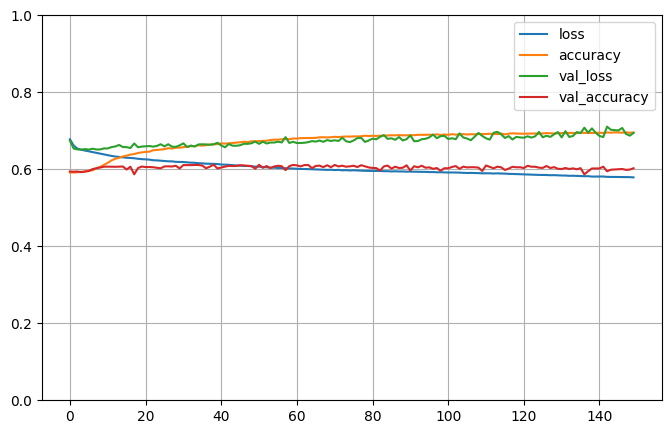


Testing # 1 4
2023-04-11 18:06:34.307977
2023-04-11 18:06:34.308436
PREDICT
2023-04-11 18:06:35.163428
Test 1:0 10558:15456 40.59%
Predict 1:0 6691:19323 25.72%
Test sizes (26014, 1025) (26014,)
Distrib of scores: 0.38067406 mean 0.18578778 std
Range of scores: 0.027493542 to 0.98982686
Score threshold 0.5
Confusion matrix
 [[12221  3235]
 [ 7102  3456]]
Normalized matrix
 [[0.4697855  0.12435612]
 [0.27300684 0.13285154]]
Extreme scores correct, pos:neg 1358 9018
Extreme scores incorrect pos:neg 1054 4791


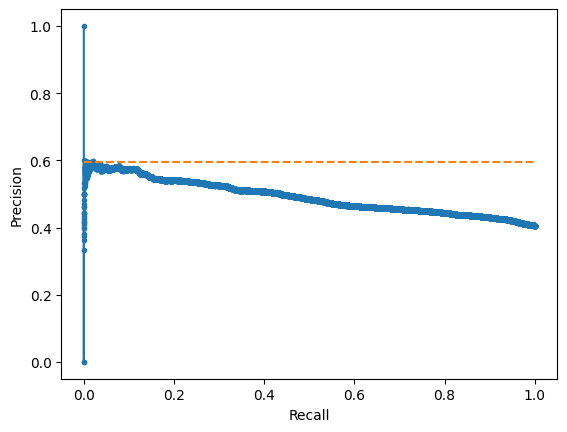

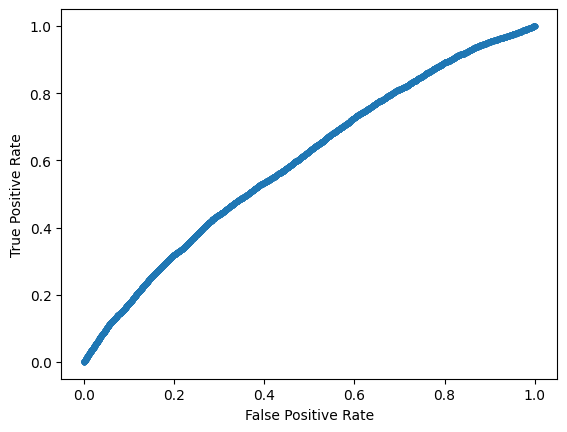

Accuracy: 60.26% Precision: 51.65% Recall: 32.73%
F1: 40.07% MCC: 0.1326
AUPRC: 49.09% AUROC: 59.81%
 accuracy [60.26370415929884]
 precision [51.65147212673741]
 recall [32.73347224853192]
 F1 [40.071888225404365]
 MCC [0.13260267392752295]
 AUPRC [49.09080680891743]
 AUROC [59.80814636208469]

Training # 1 5
2023-04-11 18:06:38.909418
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.5.validation_genes.txt
2023-04-11 18:06:40.901539
Discriminator ZERO 0
Train 1:0 42532:62018 40.68%
Valid 1:0 10708:15953 40.16%
FIT
2023-04-11 18:06:43.228850


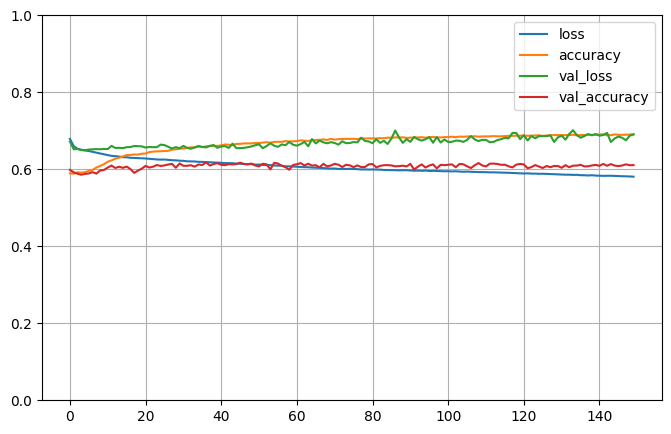


Testing # 1 5
2023-04-11 18:59:08.851496
2023-04-11 18:59:08.851672
PREDICT
2023-04-11 18:59:09.270133
Test 1:0 10708:15953 40.16%
Predict 1:0 7705:18956 28.90%
Test sizes (26661, 1025) (26661,)
Distrib of scores: 0.4066263 mean 0.19570734 std
Range of scores: 0.03053103 to 0.9959473
Score threshold 0.5
Confusion matrix
 [[12267  3686]
 [ 6689  4019]]
Normalized matrix
 [[0.46011027 0.13825438]
 [0.25089081 0.15074453]]
Extreme scores correct, pos:neg 1794 7194
Extreme scores incorrect pos:neg 1458 3342


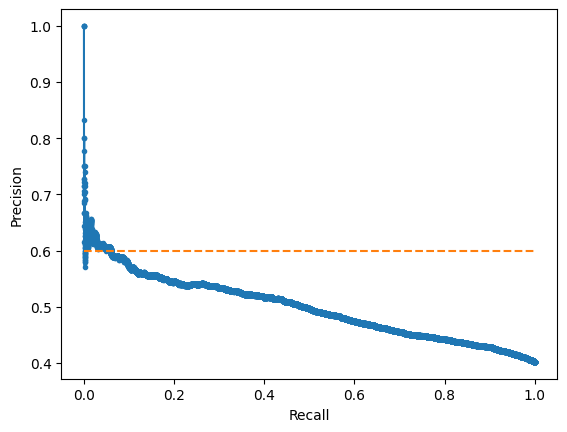

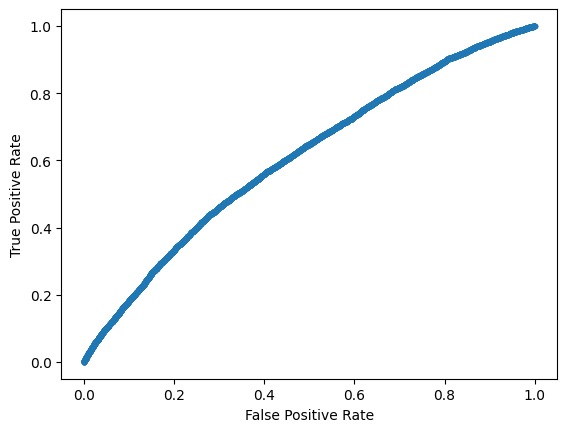

Accuracy: 61.09% Precision: 52.16% Recall: 37.53%
F1: 43.65% MCC: 0.1560
AUPRC: 49.83% AUROC: 60.91%
 accuracy [61.08548066464123]
 precision [52.16093445814406]
 recall [37.532685842360856]
 F1 [43.65394015098028]
 MCC [0.15602750744609495]
 AUPRC [49.827886383997566]
 AUROC [60.90516323620696]

Training # 2 1
2023-04-11 18:59:12.871000
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.1.validation_genes.txt
2023-04-11 18:59:14.094610
Discriminator ZERO 0
Train 1:0 42379:62864 40.27%
Valid 1:0 10861:15107 41.82%
FIT
2023-04-11 18:59:15.887343


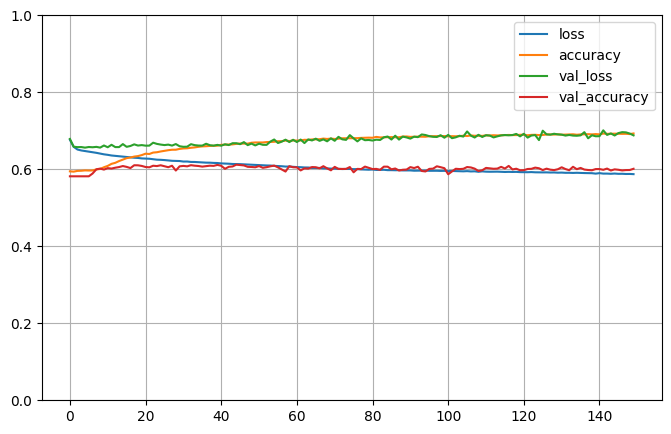


Testing # 2 1
2023-04-11 19:49:41.080240
2023-04-11 19:49:41.080318
PREDICT
2023-04-11 19:49:41.358378
Test 1:0 10861:15107 41.82%
Predict 1:0 7591:18377 29.23%
Test sizes (25968, 1025) (25968,)
Distrib of scores: 0.39296412 mean 0.18226807 std
Range of scores: 0.02909029 to 0.88488597
Score threshold 0.5
Confusion matrix
 [[11565  3542]
 [ 6812  4049]]
Normalized matrix
 [[0.44535582 0.13639864]
 [0.26232286 0.15592267]]
Extreme scores correct, pos:neg 1744 7829
Extreme scores incorrect pos:neg 1154 4104


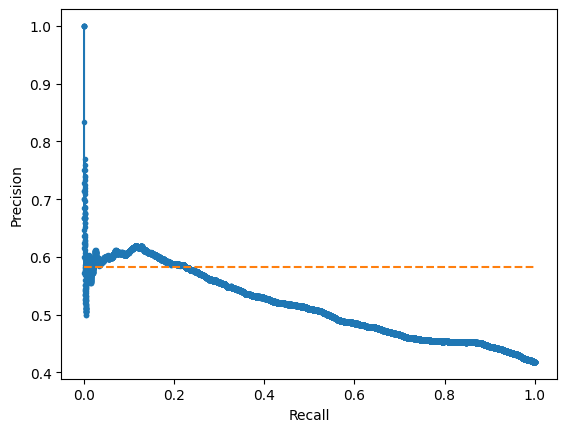

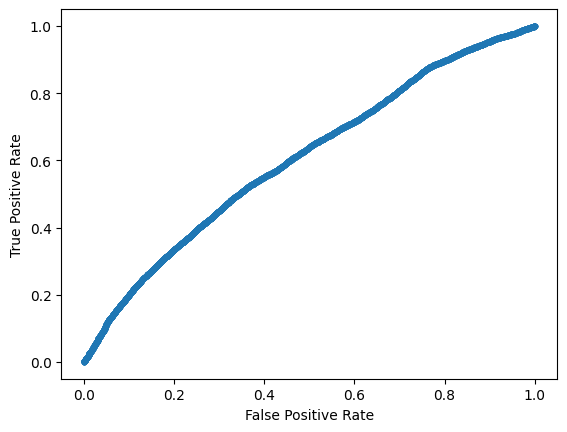

Accuracy: 60.13% Precision: 53.34% Recall: 37.28%
F1: 43.89% MCC: 0.1500
AUPRC: 51.52% AUROC: 60.60%
 accuracy [60.12784966112138]
 precision [53.339480964299824]
 recall [37.28017677930209]
 F1 [43.88684153479298]
 MCC [0.15003337655312735]
 AUPRC [51.51870198260548]
 AUROC [60.60304219003054]

Training # 2 2
2023-04-11 19:49:44.752299
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.2.validation_genes.txt
2023-04-11 19:49:46.703386
Discriminator ZERO 0
Train 1:0 42997:61797 41.03%
Valid 1:0 10243:16174 38.77%
FIT
2023-04-11 19:49:47.674827


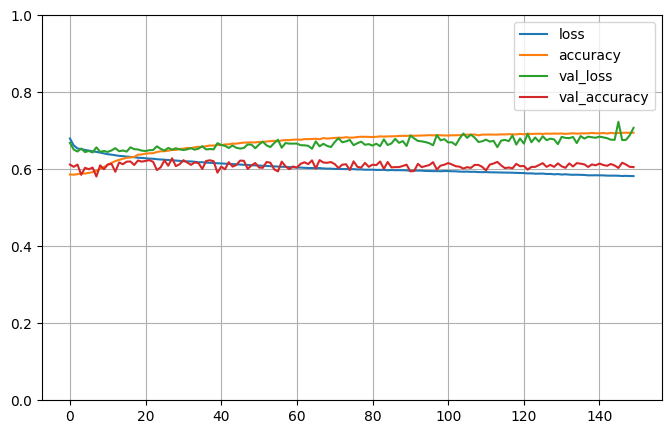


Testing # 2 2
2023-04-11 20:37:11.855106
2023-04-11 20:37:11.855167
PREDICT
2023-04-11 20:37:12.055387
Test 1:0 10243:16174 38.77%
Predict 1:0 8262:18155 31.28%
Test sizes (26417, 1025) (26417,)
Distrib of scores: 0.41330045 mean 0.2191567 std
Range of scores: 0.038480427 to 0.992277
Score threshold 0.5
Confusion matrix
 [[11956  4218]
 [ 6199  4044]]
Normalized matrix
 [[0.45258735 0.15966991]
 [0.2346595  0.15308324]]
Extreme scores correct, pos:neg 2348 8963
Extreme scores incorrect pos:neg 2317 4255


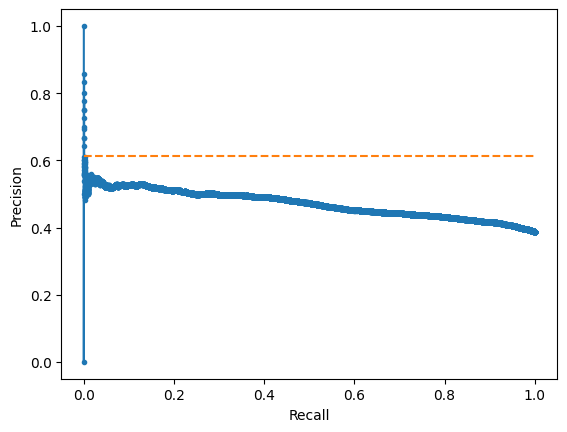

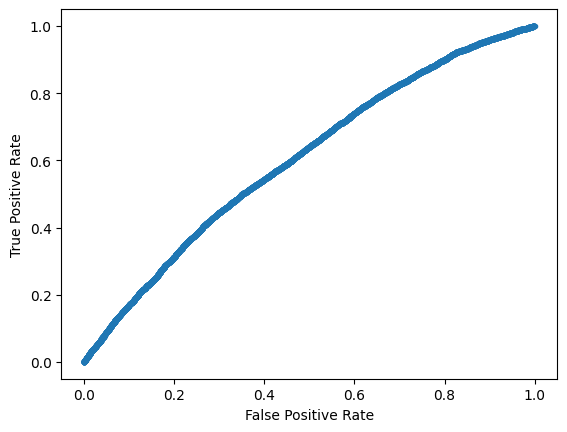

Accuracy: 60.57% Precision: 48.95% Recall: 39.48%
F1: 43.71% MCC: 0.1408
AUPRC: 47.03% AUROC: 60.41%
 accuracy [60.56705909073703]
 precision [48.946986201888166]
 recall [39.48062091184224]
 F1 [43.707106187516885]
 MCC [0.14084531682483895]
 AUPRC [47.030453857984504]
 AUROC [60.41424436037357]

Training # 2 3
2023-04-11 20:37:15.956371
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.3.validation_genes.txt
2023-04-11 20:37:17.319289
Discriminator ZERO 0
Train 1:0 42330:62726 40.29%
Valid 1:0 10910:15245 41.71%
FIT
2023-04-11 20:37:18.291303


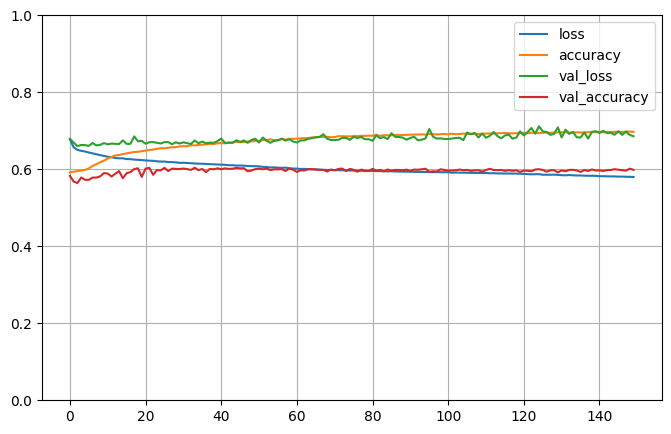


Testing # 2 3
2023-04-11 21:21:42.541435
2023-04-11 21:21:42.541856
PREDICT
2023-04-11 21:21:42.814961
Test 1:0 10910:15245 41.71%
Predict 1:0 6742:19413 25.78%
Test sizes (26155, 1025) (26155,)
Distrib of scores: 0.39348143 mean 0.17118834 std
Range of scores: 0.037143447 to 0.98334503
Score threshold 0.5
Confusion matrix
 [[12079  3166]
 [ 7334  3576]]
Normalized matrix
 [[0.46182374 0.1210476 ]
 [0.28040528 0.13672338]]
Extreme scores correct, pos:neg 1263 8237
Extreme scores incorrect pos:neg 919 4432


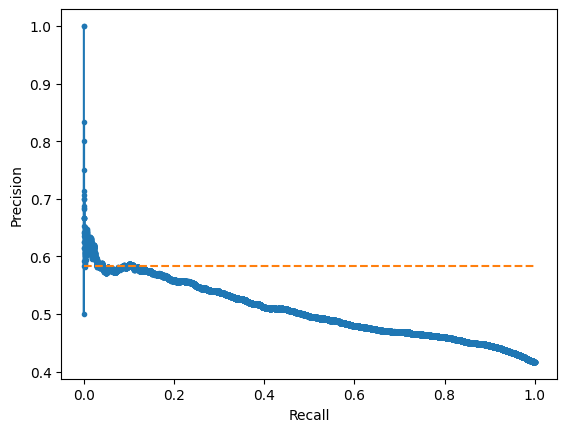

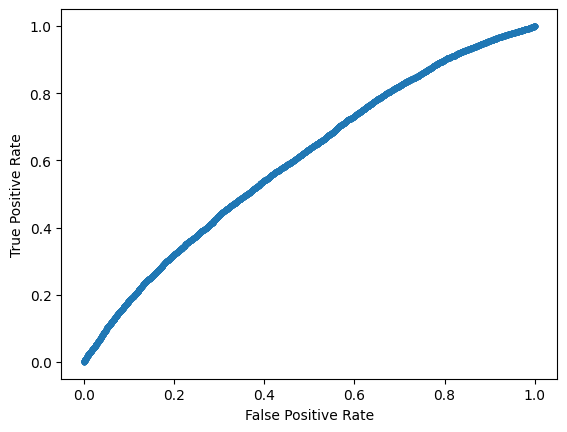

Accuracy: 59.85% Precision: 53.04% Recall: 32.78%
F1: 40.52% MCC: 0.1354
AUPRC: 50.54% AUROC: 60.24%
 accuracy [59.854712292104765]
 precision [53.040640759418565]
 recall [32.77726856095325]
 F1 [40.51665533650578]
 MCC [0.13538523448550518]
 AUPRC [50.540596918715096]
 AUROC [60.23877071684935]

Training # 2 4
2023-04-11 21:21:45.965014
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.4.validation_genes.txt
2023-04-11 21:21:47.909430
Discriminator ZERO 0
Train 1:0 42241:62452 40.35%
Valid 1:0 10999:15519 41.48%
FIT
2023-04-11 21:21:48.863845


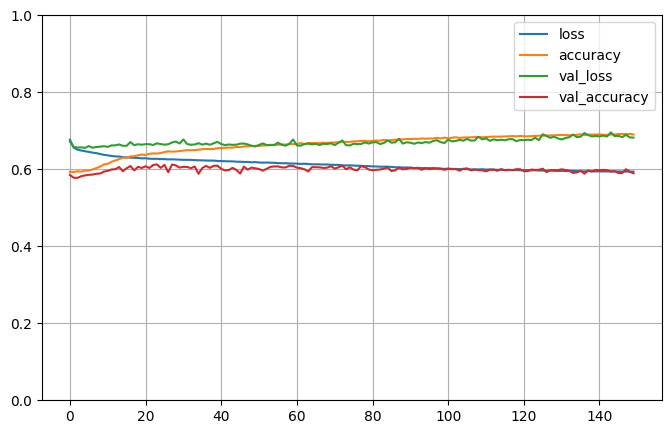


Testing # 2 4
2023-04-11 22:09:14.132216
2023-04-11 22:09:14.132348
PREDICT
2023-04-11 22:09:14.364521
Test 1:0 10999:15519 41.48%
Predict 1:0 8985:17533 33.88%
Test sizes (26518, 1025) (26518,)
Distrib of scores: 0.41727877 mean 0.180599 std
Range of scores: 0.088187054 to 0.70431036
Score threshold 0.5
Confusion matrix
 [[11083  4436]
 [ 6450  4549]]
Normalized matrix
 [[0.41794253 0.1672826 ]
 [0.24323101 0.17154386]]
Extreme scores correct, pos:neg 2546 7890
Extreme scores incorrect pos:neg 2125 3955


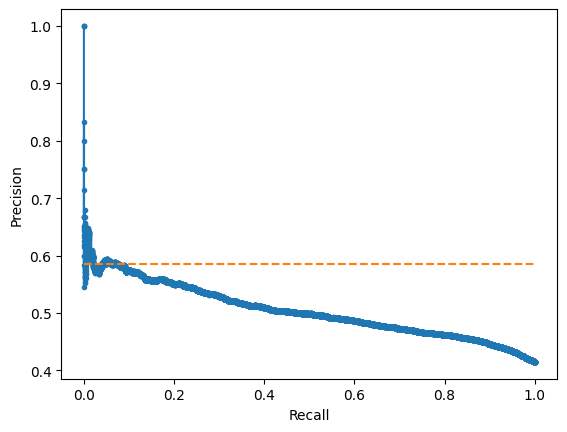

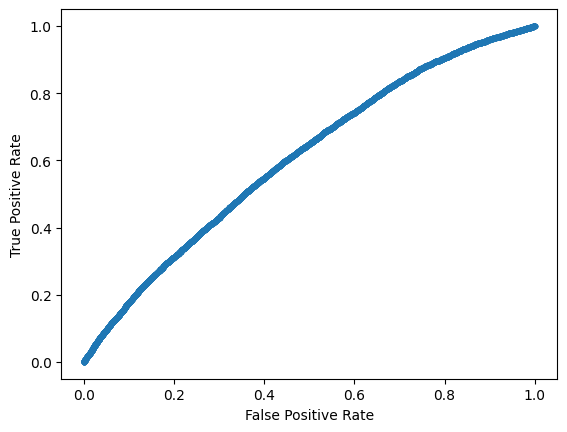

Accuracy: 58.95% Precision: 50.63% Recall: 41.36%
F1: 45.53% MCC: 0.1330
AUPRC: 50.37% AUROC: 60.75%
 accuracy [58.948638660532474]
 precision [50.62882582081246]
 recall [41.35830530048186]
 F1 [45.52642113690952]
 MCC [0.1329682210666249]
 AUPRC [50.36698624336987]
 AUROC [60.74564646086279]

Training # 2 5
2023-04-11 22:09:18.263416
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.5.validation_genes.txt
2023-04-11 22:09:20.233745
Discriminator ZERO 0
Train 1:0 43013:62045 40.94%
Valid 1:0 10227:15926 39.10%
FIT
2023-04-11 22:09:21.415575


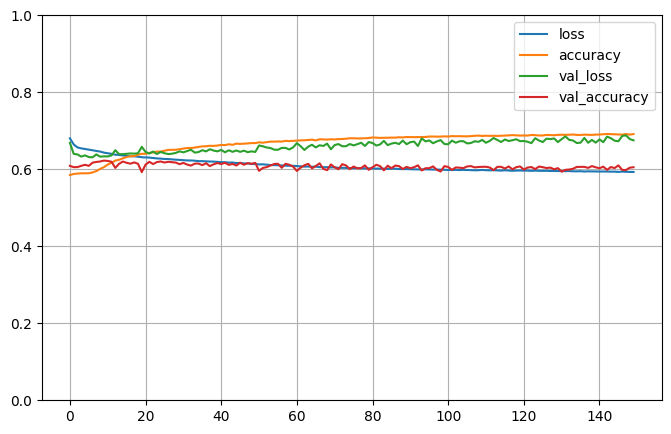


Testing # 2 5
2023-04-11 22:56:45.831797
2023-04-11 22:56:45.831864
PREDICT
2023-04-11 22:56:46.077576
Test 1:0 10227:15926 39.10%
Predict 1:0 7149:19004 27.34%
Test sizes (26153, 1025) (26153,)
Distrib of scores: 0.40490618 mean 0.18006405 std
Range of scores: 0.05138265 to 0.7733633
Score threshold 0.5
Confusion matrix
 [[12304  3622]
 [ 6700  3527]]
Normalized matrix
 [[0.47046228 0.13849272]
 [0.25618476 0.13486025]]
Extreme scores correct, pos:neg 2163 7806
Extreme scores incorrect pos:neg 2075 3832


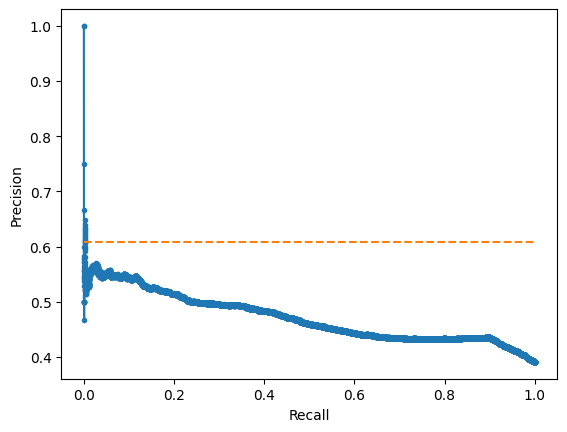

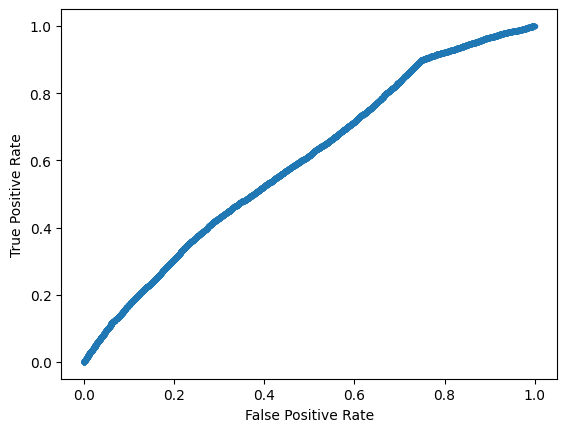

Accuracy: 60.53% Precision: 49.34% Recall: 34.49%
F1: 40.60% MCC: 0.1286
AUPRC: 47.12% AUROC: 59.92%
 accuracy [60.53225251405192]
 precision [49.33557140858861]
 recall [34.487141879339006]
 F1 [40.5962246777164]
 MCC [0.12859238907256093]
 AUPRC [47.123486730129095]
 AUROC [59.92317971154382]
2023-04-11 22:56:49.783764


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.18% std 0.67
 precision mean 51.34% std 1.77
 recall mean 36.15% std 3.08
 F1 mean 42.35% std 2.19
 MCC mean 0.1385 std 0.0128
 AUPRC mean 49.45% std 1.76
 AUROC mean 60.48% std 0.90
 accuracy [[60.112401369659075], [59.33597319524825], [60.95890410958904], [60.26370415929884], [61.08548066464123], [60.12784966112138], [60.56705909073703], [59.854712292104765], [58.948638660532474], [60.53225251405192]]
 precision [[48.86609851220569], [52.45085524636202], [53.02013422818792], [51.65147212673741], [52.16093445814406], [53.339480964299824], [48.946986201888166], [53.040640759418565], [50.62882582081246], [49.33557140858861]]
 recall [[32.03598484848485], [37.13846710050615], [36.63768115942029], [32.73347224853192], [37.532685842360856], [37.28017677930209], [39.48062091184224], [32.77726856095325], [41.35830530048186], [34.487141879339006]]
 F1 [[38.700451867528464], [43.48608318340565], [43.3321906067878], [40.071888225404365], [43.65394015098028], [43.88684153479298